# Section 4 - Profit prediction model for a new users 

In [1]:
# packages used
import mysql.connector
import pandas as pd 
import matplotlib.pyplot as plt  
from datetime import datetime

# Use ggplot as plt style
plt.style.use('ggplot') 

In [2]:
cnx = mysql.connector.connect(user='root', password='8xIt7ASAOzIh',
                              host='dw-sandbox-rds.ccia3ag00jrs.us-west-2.rds.amazonaws.com',
                              database='dw')

In [3]:
query = """
    SELECT ID, 
        IF(baby_registry_101_subscribed_at IS NULL, 0, 1) + IF(newsletter_subscribed_at IS NULL, 0, 1) + IF(pregnancy_weekly_subscribed_at IS NULL, 0, 1) + IF(sponsored_subscribed_at IS NULL, 0, 1) AS DIVERSITY,
        DATEDIFF(NOW(), original_arrival_date) AS URGENCY,
        DATEDIFF(NOW(), created_at) AS Lifetime,
        source,
        transactional_delivered
    FROM dim_users 
    WHERE is_active IS NOT NULL
      AND original_arrival_date IS NOT NULL
      AND source IS NOT NULL
      AND created_at IS NOT NULL
      AND DATEDIFF(NOW(), original_arrival_date) BETWEEN -365 AND 365
    """
df = pd.read_sql_query(query, con = cnx)


In [4]:
df.transactional_delivered.describe()

count    674326.000000
mean          5.126544
std          11.033547
min           0.000000
25%           0.000000
50%           1.000000
75%           4.000000
max         401.000000
Name: transactional_delivered, dtype: float64

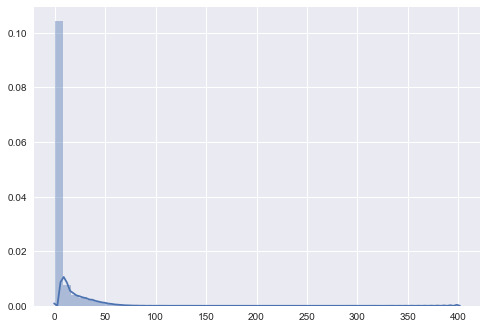

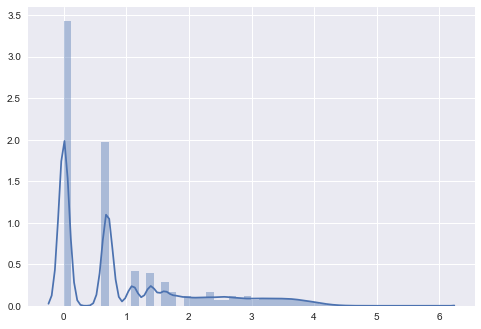

In [5]:
import seaborn as sns
import numpy as np
sns.set(color_codes=True)
sns.distplot(df.transactional_delivered.values)
plt.show()
sns.distplot(np.log((df.transactional_delivered.values +  1)))
plt.show()

# Goal : Make a profit/ Non-profit classifier (prediction model)

In [5]:
def transaction_class(data):
    if data == 0: 
        return 0
    else: 
        return 1

In [6]:
df["class"] = df.transactional_delivered.apply(transaction_class)

In [6]:
df.describe()

,ID,DIVERSITY,URGENCY,Lifetime,transactional_delivered,class
count,6.756540e+05,675654.000000,675654.000000,675654.000000,675654.000000,675654.000000
mean,9.705274e+05,2.320740,128.994203,211.535348,5.117652,0.588872
std,3.740490e+05,1.237717,136.888824,127.831085,11.025175,0.492039
min,1.000000e+00,0.000000,-365.000000,50.000000,0.000000,0.000000
25%,6.332335e+05,2.000000,28.000000,169.000000,0.000000,0.000000
50%,9.447525e+05,2.000000,134.000000,169.000000,1.000000,1.000000
75%,1.347754e+06,3.000000,233.000000,215.000000,4.000000,1.000000
max,1.574569e+06,4.000000,365.000000,2574.000000,401.000000,1.000000


In [17]:
import sklearn.preprocessing as preprocessing
import numpy as np

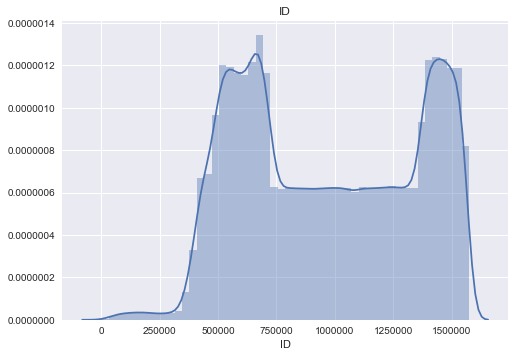

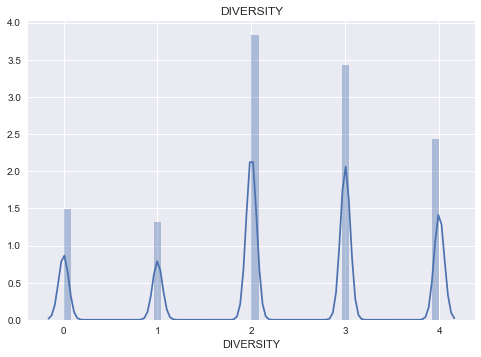

In [12]:
for i in range(0,2) :
    sns.distplot(df.iloc[:, i])
    plt.title(df.columns[i])
    plt.show()

# Model building 

In [7]:
from sklearn.cross_validation import train_test_split
from sklearn import metrics

/Users/pei-ciwu/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [8]:
X = df.iloc[:, 1:4]
y = df.iloc[:, -1]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# KNN

In [10]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)

In [14]:
# make class predictions for the testing set
import time
start_time = time.clock()
knn.fit(X_train, y_train)
y_pred_class = knn.predict(X_test)

In [15]:
# check the classification accuracy of KNN's predictions
metrics.accuracy_score(y_test, y_pred_class)


0.83679159103581635

In [16]:
print time.clock() - start_time, "seconds"

143.699496 seconds


# NB

In [17]:
# import and instantiate Multinomial Naive Bayes (with the default parameters)
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

In [18]:
X.describe()

,DIVERSITY,URGENCY,Lifetime
count,674326.000000,674326.000000,674326.000000
mean,2.322823,129.520747,212.344686
std,1.237479,136.630098,127.638897
min,0.000000,-365.000000,51.000000
25%,2.000000,29.000000,170.000000
50%,2.000000,134.000000,170.000000
75%,3.000000,234.000000,216.000000
max,4.000000,365.000000,2575.000000


In [19]:
# transform urgency to positive + 365
X_nb = X
X_nb.URGENCY = X_nb + 365

In [20]:
X_train_nb, X_test_nb, y_train_nb, y_test_nb = train_test_split(X_nb, y, random_state=1)

In [21]:
start_time = time.clock()
nb.fit(X_train_nb, y_train_nb)
y_pred_class = nb.predict(X_test_nb)

In [22]:
metrics.accuracy_score(y_test_nb, y_pred_class)


0.62491250548694399

In [23]:
print time.clock() - start_time, "seconds"

0.273904 seconds


# Logistic regression 

In [15]:
start_time = time.clock()
from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression()
logistic.fit(X_train, y_train)
y_pred_class = logistic.predict(X_test)
metrics.accuracy_score(y_test, y_pred_class)


0.80598411025729066

In [16]:
print time.clock() - start_time, "seconds"

1.828483 seconds


# SVM

In [13]:
import time
start_time = time.clock()
from sklearn.svm import SVC
svm = SVC(C=1.0, kernel="rbf", tol=0.001)
svm.fit(X_train, y_train)
y_pred_class = svm.predict(X_test)
metrics.accuracy_score(y_test, y_pred_class)


20325.583691 seconds


In [ ]:
print time.clock() - start_time, "seconds"

# Conlusion

Here, we tried KNN, NB, Logistic and SVM models for prediction. Thank to the efforts from section 1 - 3, we are able to use a cleaned data for our model prediction. By building a classifier, we are able to predict if a new user is profitable or not. And we among each model, we got different accuracy rate and run time. At the end of this project, we recommend to use KNN model with an accuracy rate of 83%. However, if we have more time and resourece (a more powerful server and computer), I highly recommend to use pipeline module with different parameters and thus could build a more accurate model.